In [ ]:
# Install all important libraries
!pip install yfinance
!pip install ta

In [ ]:
# NSE list Dont run
list = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS" , "BAJAJ-AUTO.NS", "GRASIM.NS","ONGC.NS", "TITAN.NS" , "SHREECEM.NS" ,\
        "NESTLEIND.NS", "GAIL.NS", "CIPLA.NS", "BHARTIARTL.NS" ,"NTPC.NS", "TATASTEEL.NS", "COALINDIA.NS", "BAJFINANCE.NS", "ICICIBANK.NS",\
       "BAJAJFINSV.NS", "WIPRO.NS", "HINDALCO.NS" , "HDFCLIFE.NS", "MARUTI.NS", "RELIANCE.NS", "TCS.NS", "LT.NS", "INDUSINDBK.NS", "ITC.NS" , "TECHM.NS"]

In [ ]:
# SGX list Dont run
list = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
        "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
        "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [ ]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


**MA Crossover strategy:**

---



Long term / Slow
Short Term / Fast

Rules --> Variables --> Parameters

Rule --> Short Term Moving average Crosses a Long term Moving average
Variables --> Short MA / Long MA
Parameters --> 5 and 21


In [ ]:
# Making a class for the strategy
# init method to construct and provide all the variables that will be required by the strategy

class MA_Crossover():

  def __init__(self, symbol, start, end, STMA_window, LTMA_window, interval):

    self.symbol = symbol
    self.STMA_window = STMA_window
    self.LTMA_window= LTMA_window
    self.start = start
    self.end = end
    self.interval = interval
    #self.results = None
    self.prepare_data()


  def prepare_data(self):

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    indicator_1 = SMAIndicator(close = hist_stock["Close"], window = self.STMA_window, fillna= False)
    STMA = indicator_1.sma_indicator()

    indicator_2 = SMAIndicator(close = hist_stock["Close"], window = self.LTMA_window, fillna= False)
    LTMA = indicator_2.sma_indicator()

    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["STMA"] = STMA
    bt_data["LTMA"] = LTMA
    bt_data = bt_data.dropna()
    self.data = bt_data

  def strategy(self):
    bt_data = self.data.copy()
    bt_data["Position"] = np.where(bt_data['STMA'] > bt_data['LTMA'], 1.0, -1.0)
    bt_data["Signal"] = bt_data['Position'].diff()
    bt_data = bt_data.dropna()

    bt_data['Stock_Returns'] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data["Strategy_Returns"] = bt_data["Stock_Returns"] * bt_data["Position"].shift(1)

    self.visualise_data = bt_data

  def visualise_strategy(self):

    print("----------------------------------------")
    print("Visualising the strategy crossover periods")
    print("----------------------------------------")

    bt_data = self.visualise_data

    plt.figure(figsize=(15, 5))
    plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.plot(bt_data["STMA"], color='b', label='Short term MA')
    plt.plot(bt_data["LTMA"], color='r', label='Long term MA')

    plt.plot(bt_data[bt_data['Signal'] == 2].index,
            bt_data['STMA'][bt_data['Signal'] == 2],
            '^', markersize = 15, color = 'g', label = 'buy/long')

    plt.plot(bt_data[bt_data['Signal'] == -2].index,
            bt_data['STMA'][bt_data['Signal'] == -2],
            'v', markersize = 15, color = 'r', label = 'sell/short')

    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Moving Averages Crossover {} Vs {}".format(self.STMA_window, self.LTMA_window))
    plt.legend()
    plt.grid()
    plt.show()

  #Basic performance Returns, Risk and Sharpe
  def performance(self):

    print("----------------------------------------")
    print("The Performance metrics")
    print("----------------------------------------")

    bt_data = self.visualise_data

    daily_ret = bt_data[["Stock_Returns", "Strategy_Returns"]].mean()
    annual_ret =  daily_ret * 252
    annual_regular_ret = np.exp(annual_ret)-1

    print("Annual regular returns:")
    print( annual_regular_ret)
    print("----------------------------------------")

    daily_std = bt_data[["Stock_Returns", "Strategy_Returns"]].std()
    annual_std =  daily_std * (252 **0.5)
    daily_regular_std = (np.exp(bt_data[["Stock_Returns", "Strategy_Returns"]])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5)


    print('Annual regular standard deviation:')
    print(annual_regular_std)
    print("----------------------------------------")

    sr = annual_regular_ret/ annual_regular_std

    print("The Sharpe Ratio:")
    print(sr)
    print("----------------------------------------")

  #Additional graphs if needed
  def returns_plot(self):
    bt_data = self.visualise_data
    title = "Returns plot for MA Crossover of {} Vs {} for the stock {}".format(self.STMA_window, self.LTMA_window, self.symbol)
    bt_data[["Stock_Returns", "Strategy_Returns"]].cumsum().apply(np.exp).plot(title = title, figsize=(15,6))

  def drawdown_plot(self):
    bt_data = self.visualise_data
    bt_data["Gross_Cum_Returns"] = bt_data["Strategy_Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
    bt_data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()

    title = "Drawdown plot for MA Crossover of {} Vs {} for the stock {}".format(self.STMA_window, self.LTMA_window, self.symbol)
    bt_data[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(title = title, figsize =(15,6))

    drawdown = bt_data["Cum_Max"] - bt_data["Gross_Cum_Returns"]

    print ("The maximum drawdown of the strategy is" , drawdown.max() )
    print("----------------------------------------")

    zero_periods = drawdown[drawdown == 0]
    delta_values = zero_periods.index[1:] - zero_periods.index[:-1]

    print( "The maximum period of drawdown is", delta_values.max() )
    print("----------------------------------------")



----------------------------------------
Visualising the strategy crossover periods
----------------------------------------


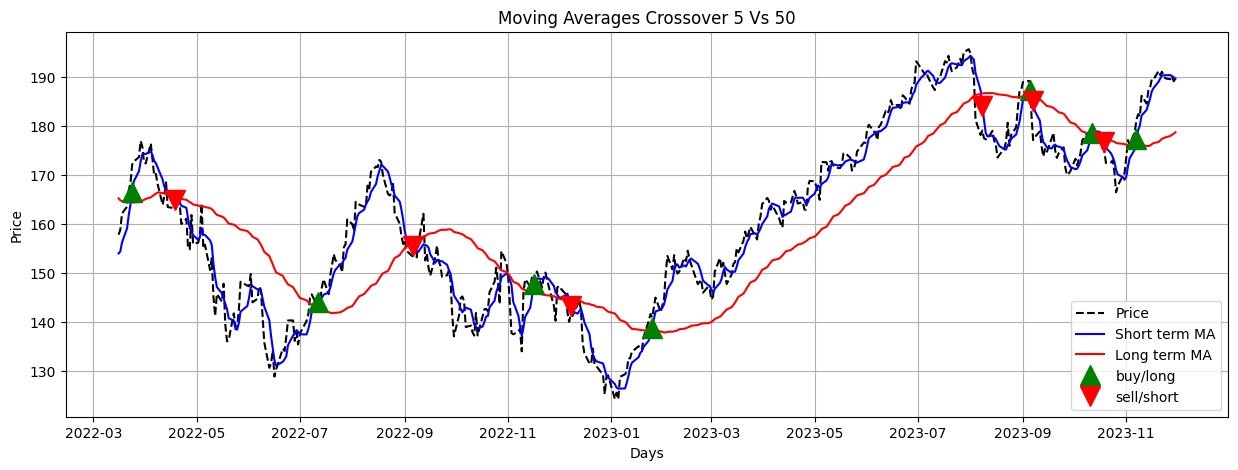

----------------------------------------
The Performance metrics
----------------------------------------
Annual regular returns:
Stock_Returns       0.114018
Strategy_Returns    0.074285
dtype: float64
----------------------------------------
Annual regular standard deviation:
Stock_Returns       0.293155
Strategy_Returns    0.293617
dtype: float64
----------------------------------------
The Sharpe Ratio:
Stock_Returns       0.388935
Strategy_Returns    0.252998
dtype: float64
----------------------------------------
The maximum drawdown of the strategy is 0.3667846521202307
----------------------------------------
The maximum period of drawdown is 140 days 23:00:00
----------------------------------------


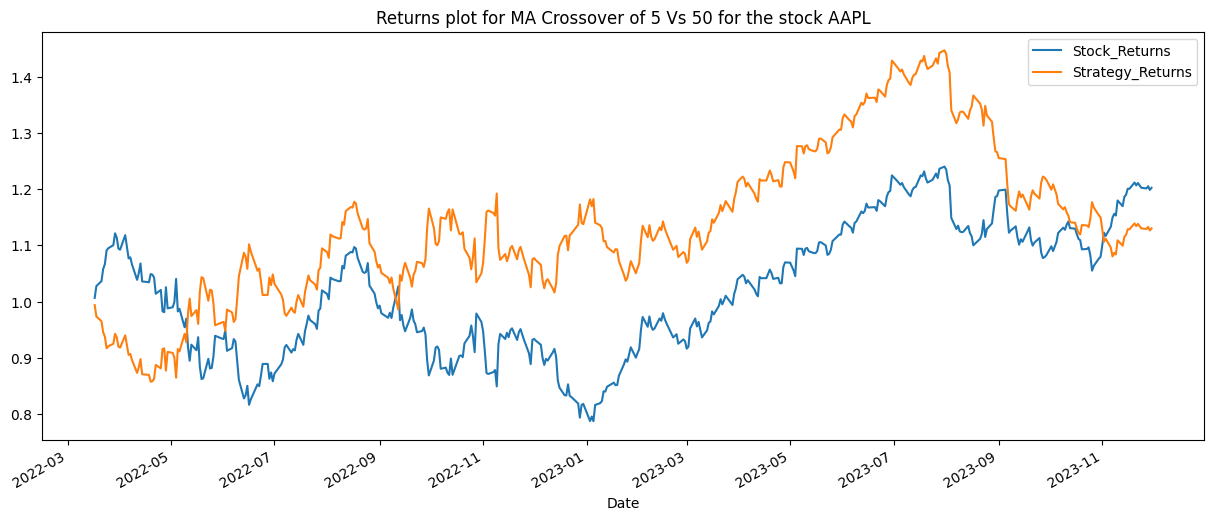

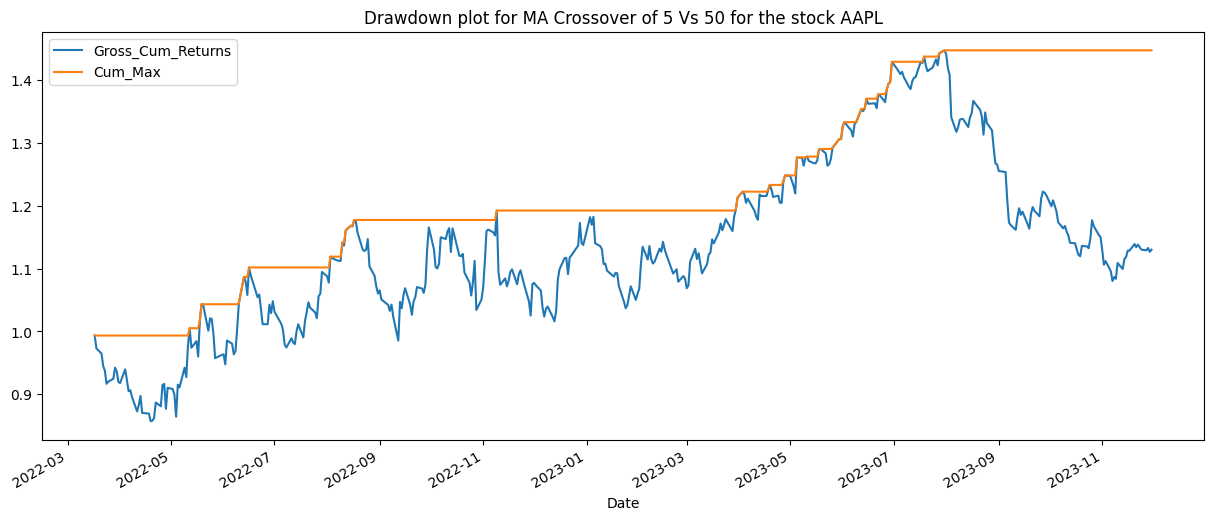

In [ ]:
# main syntax is for running a single python file (.py) as a script. It is utillised by the python interpreter
# if testing in colab  or notebooks, you can directly call the backtester and no need of __name__

if __name__ == '__main__':

  # instantiate an instance of the main class Backtester
  output = MA_Crossover("AAPL", "2022-01-01", "2023-12-01", 5, 50, "1D")

  #run the strategy
  output.strategy()

  #visulaise the crossover
  output.visualise_strategy()

  #get the performance
  output.performance()

  #plot the returns
  output.returns_plot()

  #plot the drawdown
  output.drawdown_plot()

In [ ]:
# You can run for your desired / logical parameters and store the results.
# You can also optimise with different libraries but I will not suggest optimizing.